In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import sys
sys.path.insert(0, '../../src')
from bandit import Bandits_one, Bandits_two, Bandits_three, Bandits_four


Epsilon greedy algo implementation

In [2]:
def epsilon_greedy(mab_env, T=1000, epsilon=0.1):
    k = mab_env.k                  #k represents num arms in each MAB_env, otherwise, init E[R|a]=0, N_i = 0
    estimated_rewards = np.zeros(k, dtype=float)   # estimated mean reward per arm
    num_actions = np.zeros(k, dtype=int)     # pull counts per arm

    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    #this is sort of equiv to num simulations
    for t in range(T):
        # explore vs exploit
        if np.random.rand() < epsilon:
            action = np.random.randint(k)
        else:
            action = int(np.argmax(estimated_rewards))

        observation, reward, terminated, truncated, info = mab_env.step(action)

        # incremental mean update
        num_actions[action] += 1
        estimated_rewards[action] += (reward - estimated_rewards[action]) / num_actions[action]

        actions[t] = action
        rewards[t] = reward

    return estimated_rewards, num_actions, actions, rewards


Decaying Epsilon Greedy

In [3]:
def decaying_epsilon_greedy(mab_env, T = 1000, epsilon = 0.1, alpha = 0.1):
    k = mab_env.k # same as above, represents num arms in each bandit env
    estimated_rewards = np.zeros(k, dtype=float)
    num_actions = np.zeros(k, dtype=int)  

    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    for t in range(T):
        # explore vs exploit
        if np.random.rand() < epsilon:
            action = np.random.randint(k)
        else:
            action = int(np.argmax(estimated_rewards))
        

        observation, reward, terminated, truncated, info = mab_env.step(action)

        # incremental mean update
        num_actions[action] += 1
        estimated_rewards[action] += (reward - estimated_rewards[action]) / num_actions[action]

        actions[t] = action
        rewards[t] = reward

        #algo similar to normal epsilon greedy, so have to add alpha-decay 

        epsilon = epsilon * alpha

    return estimated_rewards, num_actions, actions, rewards


UCB Algorithm 

In [4]:
def UCB(mab_env, T= 1000, c = 2):
    k = mab_env.k
    estimated_rewards = np.zeros(k, dtype=float)   # estimated mean reward per arm
    num_actions = np.zeros(k, dtype=int)     # pull counts per arm  

    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    for t in range(1, T+1):
        Ucb_value = np.zeros(k, dtype=float)  #now have a upper confidencce bound, init as inf
        for action in range(k): 
            if num_actions[action] == 0:
                Ucb_value[action] = float('inf')  # ensure each arm is selected at least once
            else:
                Ucb_value[action] = estimated_rewards[action] + c * np.sqrt(np.log(t) / num_actions[action])
                #function for updated confidence bound follows by solving for hoeffdings ineq. 
                #which yields E^hat[R|a] + c * sqrt(log(t)/N_a(t)), where c is a constant

        action = int(np.argmax(Ucb_value))
        observation, reward, terminated, truncated, info = mab_env.step(action) 

        # incremental mean update
        num_actions[action] += 1
        estimated_rewards[action] += (reward - estimated_rewards[action]) / num_actions[action]

        actions[t-1] = action   
        rewards[t-1] = reward

    return estimated_rewards, num_actions, actions, rewards  

1000 runs of each algo

In [5]:
T = 1000

# epsilon-greedy
mab_env = Bandits_one()
estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T=T, epsilon=0.1)
print("Epsilon-greedy best arm:", np.argmax(estimated_rewards))

# decaying epsilon-greedy
mab_env = Bandits_one()
estimated_rewards, num_actions, actions, rewards = decaying_epsilon_greedy(mab_env, T=T, epsilon=0.1, alpha=0.995)
print("Decaying epsilon-greedy best arm:", np.argmax(estimated_rewards))

# UCB
mab_env = Bandits_one()
estimated_rewards, num_actions, actions, rewards = UCB(mab_env, T=T, c=2.0)
print("UCB best arm:", np.argmax(estimated_rewards))
print("Estimated Rewards with upper confidence bound algo:", estimated_rewards)

#comments on results, for this exp we simmply care about the estimated reward, and use  
#np.argmax to return the arm(argument)) corresponding to the highest expected reward




Epsilon-greedy best arm: 2
Decaying epsilon-greedy best arm: 2
UCB best arm: 2
Estimated Rewards with upper confidence bound algo: [0.88289297 2.01128655 2.95392108]


The experiment repeated 20 times

In [6]:
Repeats = 20
T = 1000

result_epsilon_greedy = []
result_decaying_epsilon_greedy = []
result_UCB = []

best_arm_eg = 0
best_arm_deg = 0
best_arm_UCB = 0
#want to run 20 simulations, where one samples the reward at step t = 1 ...  1000

for r in range(Repeats):
    #eg
    mab_env = Bandits_one(random_state=r)

    estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T=T, epsilon=0.1)
    result_epsilon_greedy.append(np.mean(rewards))
    best_arm_eg += np.argmax(estimated_rewards)

    #deg
    estimated_rewards, num_actions, actions, rewards = decaying_epsilon_greedy(mab_env, T=T, epsilon=0.1, alpha=0.995)
    result_decaying_epsilon_greedy.append(np.mean(rewards))
    best_arm_deg += np.argmax(estimated_rewards)    

    #ucb
    estimated_rewards, num_actions, actions, rewards = UCB(mab_env, T=T, c=2.0)
    result_UCB.append(np.mean(rewards))
    best_arm_UCB += np.argmax(estimated_rewards)

print(f"""Results from sims: avg reward per step, best arm over {Repeats} repeats
    Epsilon-greedy: {np.mean(result_epsilon_greedy)}, {best_arm_eg/Repeats}
    Decaying Epsilon-greedy: {np.mean(result_decaying_epsilon_greedy)}, {best_arm_deg/Repeats}    
    UCB: {np.mean(result_UCB)}, {best_arm_UCB/Repeats}""")

#The results show average reward per step. 



Results from sims: avg reward per step, best arm over 20 repeats
    Epsilon-greedy: 2.865551578522511, 2.0
    Decaying Epsilon-greedy: 2.943679843108078, 2.0    
    UCB: 2.9633989076749763, 2.0


Plot of regret for the three algorithms averaged across 20 repetitions 

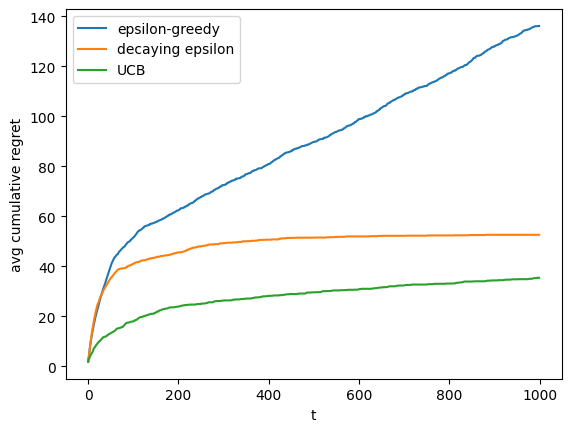

In [7]:
Repeats = 20
T = 1000

def cummulative_regret(mab_env, actions):
    return np.cumsum(mab_env.get_optimal_expected_reward() - mab_env.means[actions])
    #the regret metric for bandits is simply the sum of the reward from the optimal
    #action minus the reward from the selected action at each time step


regret_eps = np.zeros((Repeats, T))
regret_decay = np.zeros((Repeats, T))
regret_ucb = np.zeros((Repeats, T))

for r in range(Repeats):
    mab_env = Bandits_one(random_state=r)
    estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T, epsilon=0.1)
    regret_eps[r] = cummulative_regret(mab_env, actions)
    
    estimated_rewards, num_actions, actions, rewards = decaying_epsilon_greedy(mab_env, T, epsilon=0.1, alpha=0.995)
    regret_decay[r] = cummulative_regret(mab_env, actions)

    estimated_rewards, num_actions, actions, rewards = UCB(mab_env, T, c=2.0)
    regret_ucb[r] = cummulative_regret(mab_env, actions)

plt.plot(regret_eps.mean(axis=0), label="epsilon-greedy")
plt.plot(regret_decay.mean(axis=0), label="decaying epsilon")
plt.plot(regret_ucb.mean(axis=0), label="UCB")
plt.xlabel("t")
plt.ylabel("avg cumulative regret")
plt.legend()
plt.show()

Comments on 8.4, regret as a function of each algorithm is scored as UBC < Decaying EG < EG
This makes sense as one would expect the first two algorithms to converge towards the 
correct faster, which would mean less regret accumulating. For the asymptotic theory, it matches what was presented in class fairly well with the current hyperparams \epsilon = 0.1
\alpha = 0.99 and c = 2.  

Changing the hyperparams and seeing how it affects regret, an exp

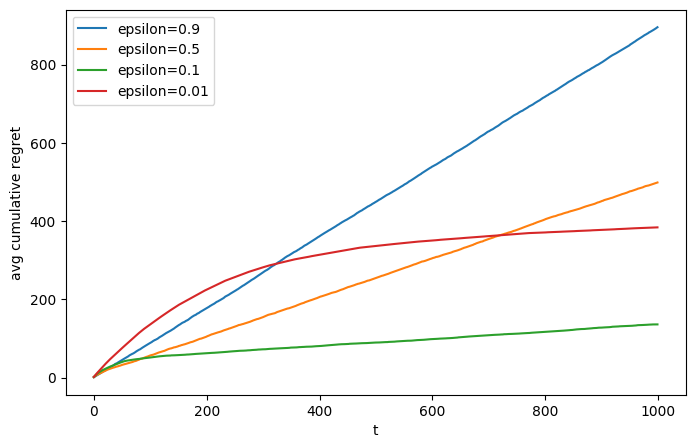

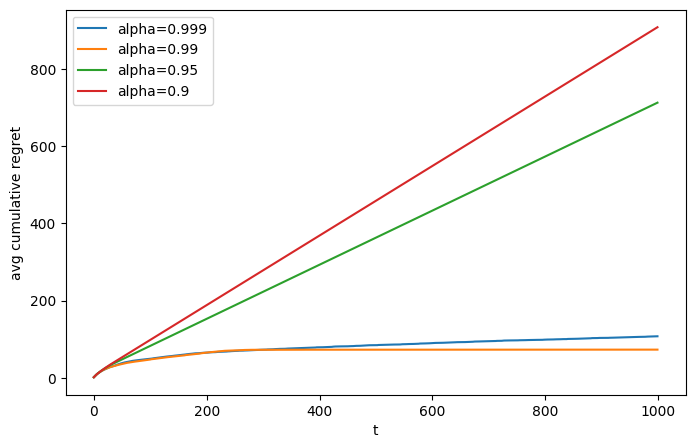

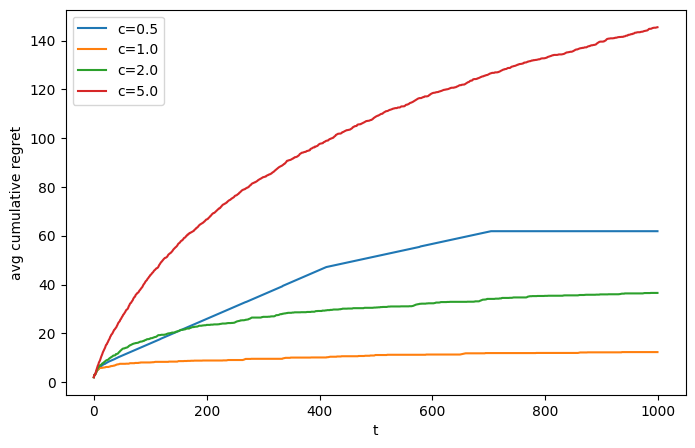

In [8]:
Repeats = 20
T = 1000

def cummulative_regret(mab_env, actions):
    return np.cumsum(mab_env.get_optimal_expected_reward() - mab_env.means[actions])

epsilons = [0.9, 0.5, 0.1, 0.01]

plt.figure(figsize=(8,5))
for epsilon in epsilons:
    regret_eps = np.zeros((Repeats, T))
    for r in range(Repeats):
        mab_env = Bandits_one(random_state=r)
        estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T, epsilon)
        regret_eps[r] = cummulative_regret(mab_env, actions)
    plt.plot(regret_eps.mean(axis=0), label=f"epsilon={epsilon}")

plt.xlabel("t")
plt.ylabel("avg cumulative regret")
plt.legend()
plt.show()

alphas = [0.999, 0.99, 0.95, 0.9]

plt.figure(figsize=(8,5))  
for alpha in alphas:
    regret_decay = np.zeros((Repeats, T))
    for r in range(Repeats):
        mab_env = Bandits_one(random_state=r)
        estimated_rewards, num_actions, actions, rewards = decaying_epsilon_greedy(mab_env, T, epsilon=0.1, alpha=alpha)
        regret_decay[r] = cummulative_regret(mab_env, actions)
    plt.plot(regret_decay.mean(axis=0), label=f"alpha={alpha}")

plt.xlabel("t")
plt.ylabel("avg cumulative regret") 
plt.legend()
plt.show()

c = [0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(8,5))
for ci in c:
    regret_ucb = np.zeros((Repeats, T))
    for r in range(Repeats):
        mab_env = Bandits_one(random_state=r)
        estimated_rewards, num_actions, actions, rewards = UCB(mab_env, T, c=ci)
        regret_ucb[r] = cummulative_regret(mab_env, actions)
    plt.plot(regret_ucb.mean(axis=0), label=f"c={ci}")

plt.xlabel("t")
plt.ylabel("avg cumulative regret") 
plt.legend()
plt.show()


A fourth medicine added(arm), now over to bandits_two() env and how to solve!

In [30]:
#example
T = 1000
epsilon = 0.9

mab_env = Bandits_two()
estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T, epsilon)
best_arm = np.argmax(estimated_rewards)

print("Best arm for Bandits_two with epsilon-greedy:", best_arm)
#have here recomputed with epsilon greedy for a new bandit environment
#ex under to show estimated best arm is equal to true best arm, and also using function def
#in bandits.py instead of np.argmax
print("Bandits_two true best arm:", mab_env.get_optimal_action())
                                              



Best arm for Bandits_two with epsilon-greedy: 2
Bandits_two true best arm: 2


Three new medicines X, Y, Z in bandits_three(), and solving the new bandit environment with the prev algos 

In [10]:
T = 1000
Repeats = 20

#Params all three algos
epsilon = 0.9
alpha = 0.995
c =2        # noticed, only got the correct solution with c = 2 for UCB here, C = 1 yielded diff answer.

mab_env = Bandits_three()
for r in range(Repeats):
    estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T, epsilon)
    best_arm_eg = np.argmax(estimated_rewards)
    estimated_rewards_2, num_actions_2, actions_2, rewards_2 = decaying_epsilon_greedy(mab_env, T, epsilon, alpha)  
    best_arm_deg = np.argmax(estimated_rewards_2)
    estimated_rewards_3, num_actions_3, actions_3, rewards_3 = UCB(mab_env, T, c)
    best_arm_ucb = np.argmax(estimated_rewards_3)


print("Best arm for Bandits_three with epsilon-greedy:", best_arm_eg, estimated_rewards)
print("Best arm for Bandits_three with decaying epsilon-greedy:", best_arm_deg, estimated_rewards_2)
print("Best arm for Bandits_three with UCB:", best_arm_ucb, estimated_rewards_3)    

#also notice that due to the variance, all algos(agents) tend to overestimate the expected reward of arm(2)



Best arm for Bandits_three with epsilon-greedy: 2 [1.95845897 1.60300364 2.42080754]
Best arm for Bandits_three with decaying epsilon-greedy: 2 [2.09218071 1.40256446 2.22186354]
Best arm for Bandits_three with UCB: 2 [1.90645718 1.49967263 2.2896427 ]


Regret for all three algorithms, solving the Bandits_three env instead of the Bandits_one 

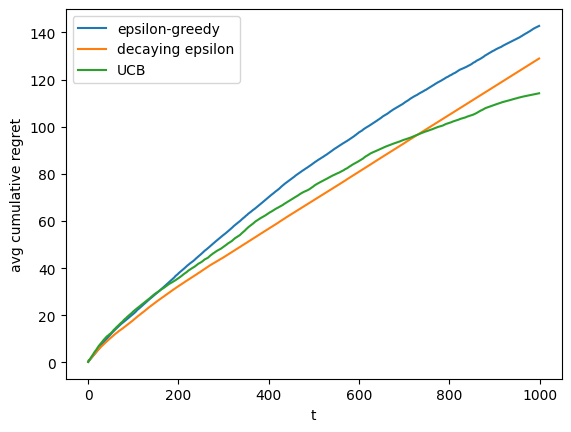

In [11]:
Repeats = 20
T = 1000

def cummulative_regret(mab_env, actions):
    return np.cumsum(mab_env.get_optimal_expected_reward() - mab_env.means[actions])
    #the regret metric for bandits is simply the sum of the reward from the optimal
    #action minus the reward from the selected action at each time step


regret_eps = np.zeros((Repeats, T))
regret_decay = np.zeros((Repeats, T))
regret_ucb = np.zeros((Repeats, T))

for r in range(Repeats):
    mab_env = Bandits_three(random_state=r)
    estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T, epsilon=0.1)
    regret_eps[r] = cummulative_regret(mab_env, actions)
    
    estimated_rewards, num_actions, actions, rewards = decaying_epsilon_greedy(mab_env, T, epsilon=0.1, alpha=0.995)
    regret_decay[r] = cummulative_regret(mab_env, actions)

    estimated_rewards, num_actions, actions, rewards = UCB(mab_env, T, c=2.0)
    regret_ucb[r] = cummulative_regret(mab_env, actions)

plt.plot(regret_eps.mean(axis=0), label="epsilon-greedy")
plt.plot(regret_decay.mean(axis=0), label="decaying epsilon")
plt.plot(regret_ucb.mean(axis=0), label="UCB")
plt.xlabel("t")
plt.ylabel("avg cumulative regret")
plt.legend()
plt.show()

This will simply be the takeaway from the experiment with regret plotted for the three algorithms solving the environment Bandits_three instead of Bandits_one which is the following: 
- as the variance is signifanctly higher for the third environment, and also the estimated rewards of each lever being more similar, gaining any kind of confidence in the estimates seem harder for all our algorithms. I therefore argue that Bandits_three is a more challenging env. than Bandits_One. 

Last part of the MAB- experiments(task8, HW1) is now about Bandits_four, which introduces a binary variable for Gene G. This gene will affect patients response to the three medicines(arms) which we were dealing with in the previous tasks. 

In [31]:
#Training two bandits, one for gene G = 0, and one for gene G = 1

#noticing in the bandits.py that the Bandits_four class takes in gene as an argument aswell as random_state
mab_env_with_gene0 = Bandits_four(gene = 0)
mab_env_with_gene1 = Bandits_four(gene = 1) 

#once again, 1000 time steps
T = 1000

#params
epsilon = 0.1
alpha = 0.995
c = 2.0

    #gene 0, with epsilon greedy: test
estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env_with_gene0, T, epsilon)
best_arm_gene0_eg = np.argmax(estimated_rewards)

estimated_rewards_gene_2, num_actions_gene_2, actions_gene_2, rewards_gene_2 = epsilon_greedy(mab_env_with_gene1, T, epsilon)
best_arm_gene1 = np.argmax(estimated_rewards_gene_2)


print("Best arm for Bandits_four with gene 0 using epsilon-greedy:", best_arm_gene0_eg)
print("Best arm for Bandits_four with gen using decaying epsilon-greedy:",best_arm_gene1)

#check to see estimated best arm matches true best arm
print("best arm for bandit four with gene 0 true best arm:", mab_env_with_gene0.get_optimal_action())
print("best arm for bandit four with gene 1 true best arm:", mab_env_with_gene1.get_optimal_action())
#takeaway, similar algo for bandit_four gives different optimal arm depending on gene



Best arm for Bandits_four with gene 0 using epsilon-greedy: 2
Best arm for Bandits_four with gen using decaying epsilon-greedy: 0
best arm for bandit four with gene 0 true best arm: 2
best arm for bandit four with gene 1 true best arm: 0


How to evaluate if gene G has a continous activation value \elem [0,1]

In [84]:
import random
e = random.randint(0,1)
T = 1000
Repeats = 20
random_state = r

epsilon = 0.1
#this is moreso a simplification, not how one should approach the task. 
est_rewards_multisim = []

for r in range(Repeats):
    mab_env = Bandits_four(gene = e, random_state= 42 +r) 
    estimated_rewards, num_actions, actions, rewards = epsilon_greedy(mab_env, T, epsilon)
    best_arm = np.argmax(estimated_rewards) 
    est_rewards_multisim.append(estimated_rewards)

print(best_arm, estimated_rewards)
print(f"the above numbers are simply the estimate from repeat 20 of 1000 sims")
print(mab_env_with_gene0.get_optimal_action(), mab_env_with_gene0.get_optimal_expected_reward(), mab_env_with_gene0.means[0])
print(mab_env_with_gene1.get_optimal_action(), mab_env_with_gene1.get_optimal_expected_reward(), mab_env_with_gene1.means[1])    

for row in est_rewards_multisim:
    print(row)

2 [1.15571477 2.01540723 2.36994051]
the above numbers are simply the estimate from repeat 20 of 1000 sims
2 2.2 [1.  2.  2.2]
0 3.0 [3.  1.  2.2]
[0.83359618 1.73582025 2.25298667]
[0.93148441 1.94541041 2.11859888]
[0.93299562 2.00691159 1.68197467]
[0.794843   1.89701957 2.1777583 ]
[1.15095024 2.0172643  1.89658292]
[0.93124819 1.97666958 1.89581258]
[0.56426784 1.9697754  1.89587008]
[1.09598672 1.86730116 2.14610333]
[1.00572964 2.07412076 2.02810905]
[0.95862117 1.89112245 2.33237414]
[0.7373242  1.95091174 2.05756809]
[0.92647597 1.99514725 1.98044507]
[1.22338666 1.9849518  2.2731133 ]
[0.86321474 2.04439495 2.21141623]
[1.07669933 2.13702955 2.29189668]
[1.03141187 2.02214891 1.89947702]
[0.75446318 1.9645733  1.60623631]
[0.91067968 2.02635631 1.61020835]
[1.01876832 1.95899833 2.27082345]
[1.15571477 2.01540723 2.36994051]


realistically, to estimate a new mean for gene expression equal to 0.5, one would have to do linear interpolation of the reward, meaning the new reward will be 0.5*exp_reward(gene = 0) + 0.5*exp_reward(gene = 1), and then simulate with an algo(epsilon-greedy, deg, UCB etc)..